In [2]:
import numpy as np
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [3]:
pd.set_option('display.max_colwidth', None)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load Data

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Classroom/GP 2023.02 IC/archive/Training.csv')
test = pd.read_csv('/content/drive/MyDrive/Classroom/GP 2023.02 IC/archive/Testing.csv')

In [63]:
train_heart = pd.read_csv('/content/drive/MyDrive/Classroom/GP 2023.02 IC/archive/heart.csv')
train_covid = pd.read_csv('/content/drive/MyDrive/Classroom/GP 2023.02 IC/archive/covid.csv', on_bad_lines='skip', sep=';')

<ipython-input-63-46c104043eb7>:2: DtypeWarning: Columns (21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  train_covid = pd.read_csv('/content/drive/MyDrive/Classroom/GP 2023.02 IC/archive/covid.csv', on_bad_lines='skip', sep=';')


In [76]:
print(f"train shape - {train.shape}")
print(f"train shape - {test.shape}")
print(f"Heart shape - {train_heart.shape}")
print(f"Covid shape - {train_covid.shape}")

train shape - (4920, 132)
train shape - (42, 132)
Heart shape - (303, 14)
Covid shape - (8866, 28)


In [9]:
train.isnull().sum()

itching                    0
skin_rash                  0
nodal_skin_eruptions       0
continuous_sneezing        0
shivering                  0
                        ... 
blister                    0
red_sore_around_nose       0
yellow_crust_ooze          0
prognosis                  0
Unnamed: 133            4920
Length: 134, dtype: int64

In [10]:
train.drop('Unnamed: 133', axis=1, inplace=True)

In [11]:
train.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


# Split Data

In [67]:
from sklearn.preprocessing import LabelEncoder

def label_encode_columns(df):
    label_encoder = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype == 'category':
            df[column] = label_encoder.fit_transform(df[column])
    return df

In [13]:
def log_normalization(df):
    for column in df.columns:
      df[column] = np.log1p(df[column].astype(np.float64))
    return df

In [14]:
train = label_encode_columns(train)
test = label_encode_columns(test)

y = train.pop('prognosis')
y_test_2 = test.pop('prognosis')

train = log_normalization(train)
test = log_normalization(test)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3)

# Ml Model

In [16]:
svm = SVC(kernel='linear', random_state=42)

svm.fit(X_train, y_train)

y_pred_train = svm.predict(X_train)

y_pred_test = svm.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f'Accuracy Train (SVM): {acc_train}')
print(f'Accuracy Test (SVM): {acc_test}')

Accuracy Train (SVM): 1.0
Accuracy Test (SVM): 1.0


In [28]:
from sklearn.metrics import roc_auc_score

svm = SVC(kernel='linear', random_state=42, probability=True)
svm.fit(X_train, y_train)

y_prob_train = svm.predict_proba(X_train)
y_prob_test = svm.predict_proba(X_test)
svm_probs = svm.predict_proba(test)

roc_auc_train = roc_auc_score(y_train, y_prob_train, multi_class='ovr')
roc_auc_test = roc_auc_score(y_test, y_prob_test, multi_class='ovr')
roc_auc_test_2 = roc_auc_score(y_test_2, svm_probs, multi_class='ovr')

print(f'ROC AUC Train (SVM): {roc_auc_train}')
print(f'ROC AUC Test (SVM): {roc_auc_test}')
print(f'ROC AUC Test 2 (SVM): {roc_auc_test_2}')

ROC AUC Train (SVM): 1.0
ROC AUC Test (SVM): 1.0
ROC AUC Test 2 (SVM): 1.0


In [31]:
train_heart.head()

y_heart = train_heart.pop('output')

train_heart = label_encode_columns(train_heart)
train_heart = log_normalization(train_heart)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_heart, y_heart, test_size=0.3, random_state=13)

In [58]:
import xgboost as xgb

xgboost = xgb.XGBClassifier(booster = 'gbtree', learning_rate = 0.2, max_depth = 4, n_estimators = 160, gamma=0.3)

xgboost.fit(X_train,y_train)

xgb_probs = xgboost.predict_proba(X_test)

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

baseline = [0 for _ in range(len(y_test))]

xgb_probs_pos = xgb_probs[:, 1]

baseline_auc = roc_auc_score(y_test, baseline)

xgb_auc = roc_auc_score(y_test, xgb_probs_pos)

base_fpr, base_tpr, _ = roc_curve(y_test, baseline)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs_pos)

print(f'Baseline: ROC AUC = {baseline_auc :.5f}')
print(f'XGBoost heart attack risk ROC AUC = {xgb_auc :.5f}')

Baseline: ROC AUC = 0.50000
XGBoost heart attack risk ROC AUC = 0.86324


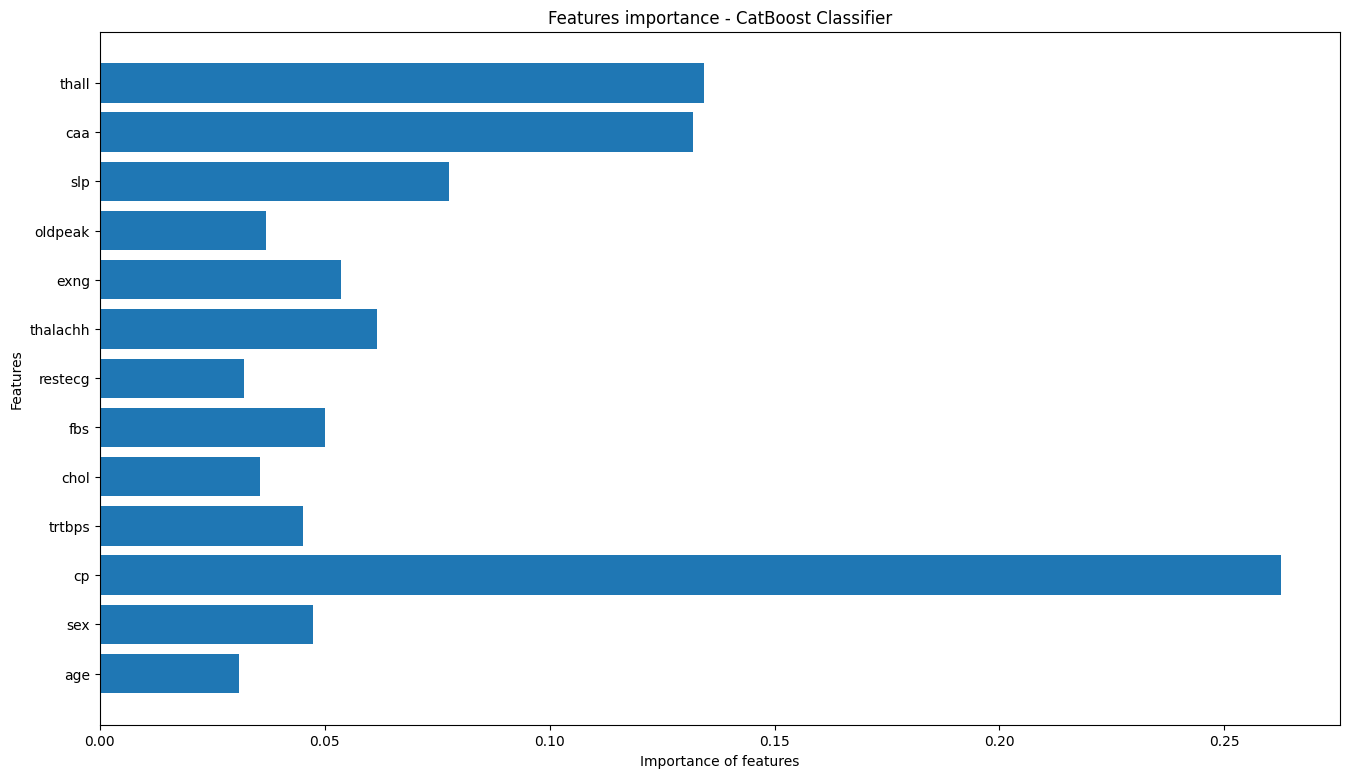

In [75]:
from matplotlib import pyplot as plt

feature_importances = xgboost.feature_importances_

feature_names = [f'{i}' for i in train_heart.columns if i != 'output']

plt.figure(figsize=(16, 9))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Features importance - CatBoost Classifier')
plt.show()

In [65]:
train_covid.describe().T

,count,unique,top,freq
id,2188226,2188162,zgUqGir5UA,2
dataNotificacao,2186719,1174307,2020-05-18T03:00:00.000Z,29334
dataInicioSintomas,2188226,1051,2020-05-10T03:00:00.000Z,56376
dataNascimento,2188226,79093,2020-04-28T03:00:00.000Z,17250
sintomas,2152577,1285,Outros,340684
profissionalSaude,2124240,3,Não,1699786
cbo,429365,2985,3222 - Técnico ou Auxiliar em Enfermagem,136407
condicoes,327478,1758,Doenças cardíacas crônicas,109029
estadoTeste,1554894,4,Concluído,924683
dataTeste,1305390,656,2020-04-28T03:00:00.000Z,93996


In [68]:
train_covid = train_covid.dropna()
train_covid = train_covid.drop([''] ,axis=1)


train_covid = label_encode_columns(train_covid)
train_covid = log_normalization(train_covid)

y_covid = train_covid.pop('classificacaoFinal')

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_covid, y_covid, test_size=0.3, random_state=13)

In [ ]:
xgboost_covid = xgb.XGBClassifier(booster = 'gbtree', learning_rate = 0.2, max_depth = 4, n_estimators = 160, gamma=0.3)

xgboost_covid.fit(X_train,y_train)

xgb_probs = xgboost_covid.predict_proba(X_test)